In [2]:
import torch
import random
import numpy as np
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [1]:
!pip install deeplake

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/617.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/617.7 kB ? eta -:--:--
     ---------------- ----------------------- 262.1/617.7 kB ? eta -:--:--
     ---------------- ----------------------- 262.1/617.7 kB ? eta -:--:--
     ------------------------------ ----- 524.3/617.7 kB 578.7 kB/s eta 0:00:01
     ------------------------------------ 617.7/617.7 kB 529.0 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:-

In [4]:
#!pip install pyjwt

In [4]:
import deeplake

Скачал через deeplake<br>
https://datasets.activeloop.ai/docs/ml/datasets/fer2013-dataset/

In [5]:
FER2013_train = deeplake.load('hub://activeloop/fer2013-train')
FER2013_test = deeplake.load('hub://activeloop/fer2013-public-test')

|

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-train



\

hub://activeloop/fer2013-train loaded successfully.



|

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-public-test



|

hub://activeloop/fer2013-public-test loaded successfully.



In [6]:
#FER2013_train нет атрибута train_data, потому что диплэйк использует какой-то другой подход для доступа к данным
#Не понял что диплейк делает с индексацией, и почему всё ломается, поэтому просто преобразовал к numpy
X_train = torch.tensor(FER2013_train.images.numpy())
y_train = torch.tensor(FER2013_train.labels.numpy())

X_test = torch.tensor(FER2013_test.images.numpy())
y_test = torch.tensor(FER2013_test.labels.numpy())

Преобразовал числовые в категориальные данные

In [8]:
# посмотртим тип "картинок"
type(X_train[10, :, :])

torch.Tensor

In [10]:
X_train.shape

torch.Size([28709, 48, 48])

In [11]:
# unsqueeze - Возвращает новый тензор с увеличенной на 1 размерностью, которая вставляется в указанную позицию.
# было torch.Size([28709, 48, 48])  ---- станет torch.Size([28709, 1, 48, 48])
# и все значения - во float

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [12]:
X_train.shape

torch.Size([28709, 1, 48, 48])

In [13]:
# Напишем свой блок свёртки с residual connection.

class ResidualBlock(torch.nn.Module):
    # Инициализация блока.
    def __init__(
        self,
        input_c,                   # Число каналов на входе.
        output_c,                  # Число каналов на выходе.
        kernel_size,               # Размер ядра.
        activation=torch.nn.ReLU,  # Класс функции активации.
    ):
        super().__init__()

        # Функция активации для нелинейности.
        self.activation = activation()

        # TODO:
        # Паддинг подбираем такой, чтобы размеры h и w не менялись
        #  (считаем, что размер ядра всегда нечётный).
        padding_size = kernel_size // 2

        # TODO:
        # Операция свёртки.
        # Создайте сверточный слой с помощью класса torch.nn.Conv2d
        # укажите количество каналов на входе и выходе, размер ядра,
        # размер паддинга и режим его выполнения (заполнение нулями)
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,
            out_channels=output_c,
            kernel_size = kernel_size,
            padding = padding_size,
            padding_mode = 'zeros'
            
        )

        # Если числа каналов у входа и выхода различаются,
        if input_c != output_c:
            # ТОDO:
            # то будем делать свёртку с ядром размера 1.
            self.correct_channels = torch.nn.Conv2d(
                            in_channels=input_c,
                            out_channels=output_c,
                            kernel_size = 1,
                
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход.

    # Прямой проход.
    def forward(self, x):
        # ТОDO:
        
        # реализуйте прямой проход
        return self.activation(self.conv(x)+self.correct_channels(x))

In [19]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.residual1 = ResidualBlock(input_c=6, output_c=6, kernel_size=3) 

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.residual2 = ResidualBlock(input_c=16, output_c=16, kernel_size=3)

        self.conv3 = torch.nn.Conv2d( # Добавил слой
            in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.pool3 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.residual3 = ResidualBlock(input_c=32, output_c=32, kernel_size=3)

        self.fc1   = torch.nn.Linear(32 * 5 * 5, 120)
        self.act4  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act5  = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(84, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.residual1(x) # Сюда воткнуто residual connection

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.residual2(x) # Сюда воткнуто residual connection

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        x = self.residual3(x) # Сюда воткнуто residual connection

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.fc3(x)

        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [20]:
# определяем, где будет обучаться наша СNN
# если есть граф процессор от Nvidia, то на нем. Если нет, то на cpu

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# отправляем туда нашу нейронку
lenet5 = lenet5.to(device)

In [21]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [22]:
# будем оптимизировать по 100 параметров одним комплектом (бачем)
batch_size = 100

# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []

train_loss_history = []

# не забываем отправить все выборки на устройство, на котором обучаем
X_test = X_test.to(device)
y_test = y_test.to(device)

# Преобразование в 1д тензер
y_train = y_train.view(-1).long()
y_test = y_test.view(-1).long()

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # делаем предсказание
        preds = lenet5.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.40150460600852966 
epoch1 - accuracy test 0.4366118609905243 
epoch2 - accuracy test 0.45945945382118225 
epoch3 - accuracy test 0.48620784282684326 
epoch4 - accuracy test 0.5059905052185059 
epoch5 - accuracy test 0.5204792618751526 
epoch6 - accuracy test 0.507662296295166 
epoch7 - accuracy test 0.5154638886451721 
epoch8 - accuracy test 0.5123990178108215 
epoch9 - accuracy test 0.5115631222724915 
epoch10 - accuracy test 0.5034828782081604 
epoch11 - accuracy test 0.5174143314361572 
epoch12 - accuracy test 0.5104485750198364 
epoch13 - accuracy test 0.507940948009491 
epoch14 - accuracy test 0.48704373836517334 
epoch15 - accuracy test 0.5112844705581665 
epoch16 - accuracy test 0.5040401220321655 
epoch17 - accuracy test 0.5054332613945007 
epoch18 - accuracy test 0.5068264007568359 
epoch19 - accuracy test 0.5040401220321655 
epoch20 - accuracy test 0.507940948009491 
epoch21 - accuracy test 0.4864864945411682 
epoch22 - accuracy test 0.518807470798492

C:\Users\dima\AppData\Local\Temp\ipykernel_15224\278083322.py:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


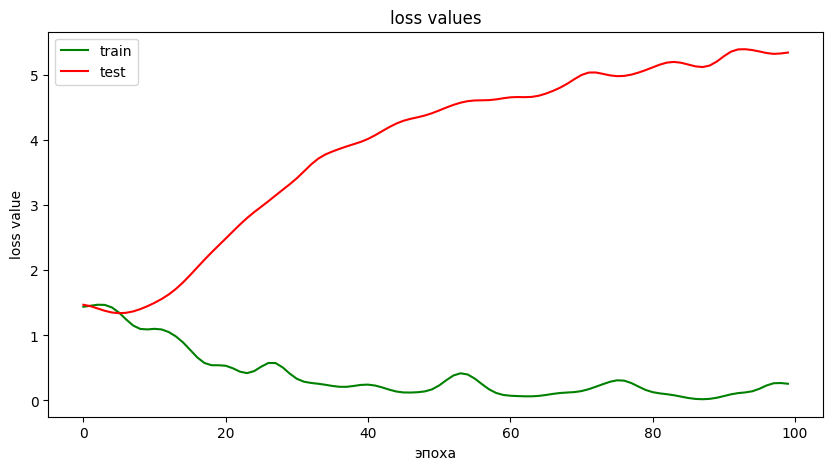

In [23]:
# строим графики - функции потерь
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()

C:\Users\dima\AppData\Local\Temp\ipykernel_15224\2679742005.py:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


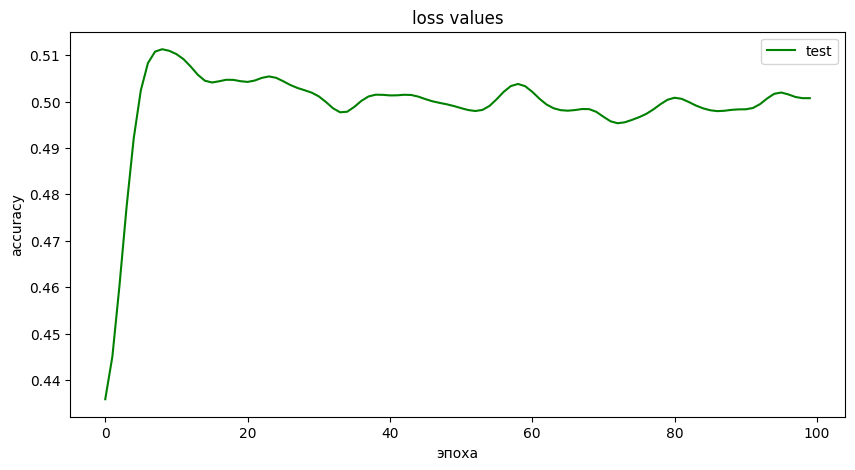

In [24]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

In [49]:
timg = X_train[1766]

torch.save(timg,'tensor.pt')

In [50]:
y_train[1766]

tensor(0)

In [51]:
# смотрим размер тензора - изображения
timg.size()

torch.Size([1, 48, 48])

In [52]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

X_test.size()


torch.Size([3589, 1, 48, 48])

In [53]:
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)


In [54]:
# считываем модель, сохраненную в dill
import torch
import torch.nn as nn
#from LeNET_5 import LeNet
import pandas as pd
import numpy as np



ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (residual1): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Identity()
  )
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (residual2): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Identity()
  )
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (residual3): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Identity()
  )
  (fc1): Linear(in_features=800, out_feature

C:\Users\dima\AppData\Local\Temp\ipykernel_15224\205738607.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


In [55]:
# смотрим тип модели
type(modelp)

__main__.LeNet5

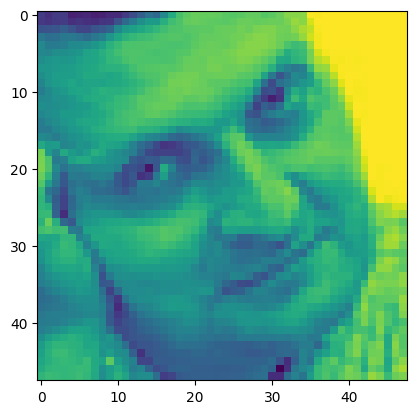

In [56]:
plt.imshow(test_data[0, :, :])
plt.show()

In [57]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

In [58]:
# проверяем
t_data.shape

torch.Size([1, 1, 48, 48])

In [59]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [60]:
# делаем предсказание
preds = modelp.forward(t_data)

In [61]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[  9.7973, -18.3658,  -0.1851,   1.6430,   2.5861,  -1.3184,   1.7005]],
       grad_fn=<AddmmBackward0>)


In [62]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [63]:
# смотрим, что предсказалось
print(prediction)

[0]


 0 = Гнев, 1 = Отвращение, 2 = Страх, 3 = Счастье, 4 = Грусть, 5 = Удивление, 6 = Нейтральность <br>
Это Гнев